### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [4]:
from scipy.interpolate import interp1d
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/mocsy-master')
import mocsy
import gsw

### where is medusa data

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


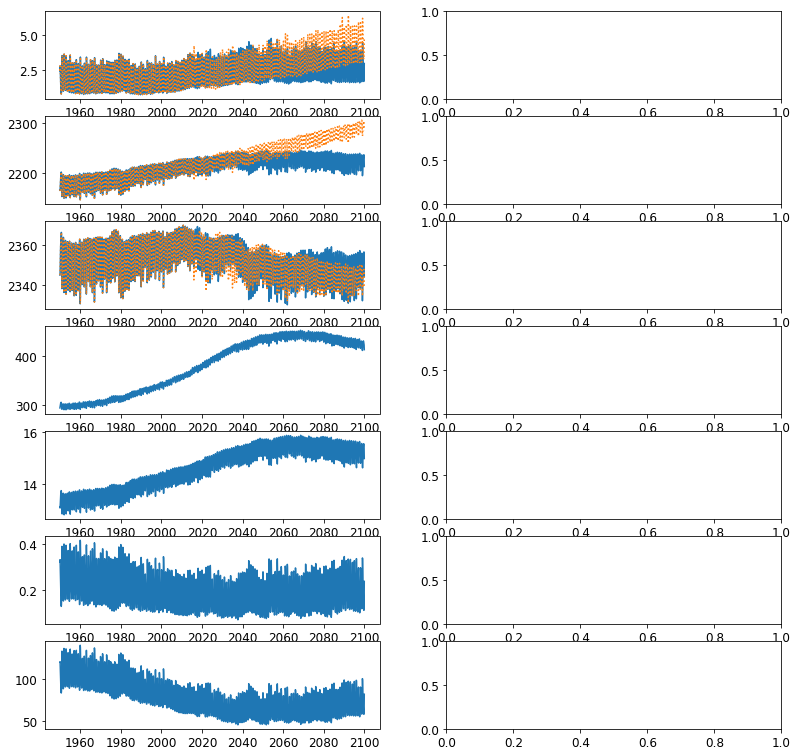

In [5]:
def make_yearlist(yrst, yrend, scen):

    tdir = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/'
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]

        t2 = glob.glob(f'{tdir}cchem-param-medusa_scen-{scen}-{yr}.nc')
        ylist.append(t2[0])

    return ylist
    
    
ty_1A = make_yearlist(1950,2099,'1A')
ty_1B = make_yearlist(1950,2099,'1B')

td_1A = xr.open_mfdataset(ty_1A)
td_1B = xr.open_mfdataset(ty_1B)

fact = 1.1
fig, axs = plt.subplots(7,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0*2].plot(td_1A.time_counter, td_1A.mn_SST.sel({'quantity': 'mean'}), label = 'scen 1A')
axs[1*2].plot(td_1A.time_counter, td_1A.mn_DIC.sel({'quantity': 'mean'}))
axs[2*2].plot(td_1A.time_counter, td_1A.mn_TA.sel({'quantity': 'mean'}))
axs[3*2].plot(td_1A.time_counter, td_1A.mn_pCO2.sel({'quantity': 'mean'}))
axs[4*2].plot(td_1A.time_counter, td_1A.mn_Revfact.sel({'quantity': 'mean'}))
axs[5*2].plot(td_1A.time_counter, td_1A.grad_dDICdz.sel({'quantity': 'mean'}))
axs[6*2].plot(td_1A.time_counter, td_1A.grad_DIC_surfdeep.sel({'quantity': 'mean'}))

axs[0*2].plot(td_1B.time_counter, td_1B.mn_SST.sel({'quantity': 'mean'}), linestyle = ':', label = 'scen 1B')
axs[1*2].plot(td_1B.time_counter, td_1B.mn_DIC.sel({'quantity': 'mean'}), linestyle = ':')
axs[2*2].plot(td_1B.time_counter, td_1B.mn_TA.sel({'quantity': 'mean'}), linestyle = ':')

In [6]:

def make_yearlist(yrst, yrend, scen):

    tdir = '/gpfs/home/mep22dku/scratch/SOZONE/Tuning/GLODAP_AnthDIC/'
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]
        if yr < 2015:
            t2 = glob.glob(f'{tdir}EstimatedDIC_{yr}.nc')
        else:      
            t2 = glob.glob(f'{tdir}EstimatedDIC_{scen}_{yr}.nc')
        ylist.append(t2[0])

    return ylist

def make_yearlist_umolL(yrst, yrend, scen):

    tdir = '/gpfs/home/mep22dku/scratch/SOZONE/Tuning/GLODAP_AnthDIC/'
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]

        t2 = glob.glob(f'{tdir}EstimatedDIC_{scen}_{yr}_umolL.nc')
        ylist.append(t2[0])

    return ylist
    
    
ty_1A = make_yearlist(1950,2099,'ssp1')
ty_1B = make_yearlist(1950,2099,'ssp3')

ty_1A_umolL = make_yearlist_umolL(1950,2099,'ssp1')
ty_1B_umolL = make_yearlist_umolL(1950,2099,'ssp3')

### make a meshmask for glodap

511207893.3958111
511207893395810.94


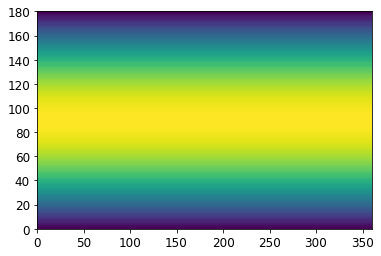

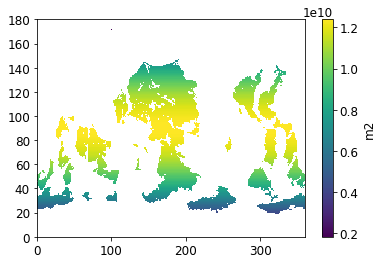

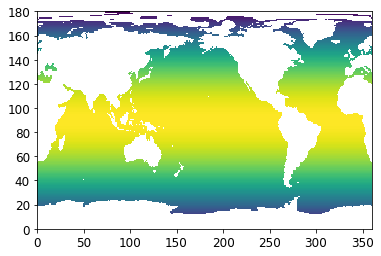

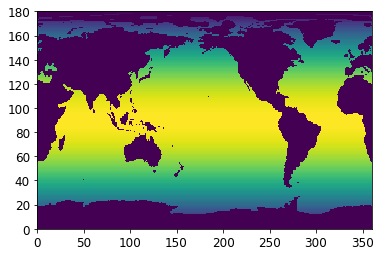

In [7]:
tdir = '/gpfs/home/mep22dku/scratch/SOZONE/Tuning/GLODAP_AnthDIC/'
t2 = glob.glob(f'{tdir}TAlk_umolL.nc')
Talk = xr.open_dataset(t2[0])

from area import area
obj = {'type':'Polygon','coordinates':[[[-180,-90],[-180,90],[180,90],[180,-90],[-180,-90]]]}
w = area(obj)
print(w/1e6)

calc_ar = np.zeros([180,360])

lats = (Talk.lat.values)
lons = (Talk.lon.values)-20

# print(lats)
# print(lons)

for lat in range(0,180):
    for lon in range(0,360):
        
        tlat = lats[lat]
        ll_lat = tlat - 0.5
        ul_lat = tlat + 0.5
        ur_lat = tlat + 0.5
        lr_lat = tlat - 0.5
        
        tlon = lons[lon] - 180 + 0.5
        ll_lon = tlon - 0.5
        ul_lon = tlon - 0.5
        ur_lon = tlon + 0.5
        lr_lon = tlon + 0.5
        
        lats_poly = [ll_lat, ul_lat, ur_lat, lr_lat]
        lons_poly = [ll_lon, ul_lon, ur_lon, lr_lon]
        
        #calc_ar[lat, lon] = polygon_area(lats_poly, lons_poly)
        obj = {'type':'Polygon','coordinates':[[[-180,-90],[-180,90],[180,90],[180,-90],[-180,-90]]]}
        obj = {'type':'Polygon','coordinates':[[[ll_lon,ll_lat],[ul_lon,ul_lat],[ur_lon,ur_lat],[lr_lon,lr_lat],[ll_lon,ll_lat]]]}
        #obj = {'type':'Polygon','coordinates':[[[-180,-90],[-180,90],[180,90],[180,-90],[-180,-90]]]}

        calc_ar[lat, lon] = area(obj)
        
#         if (lat%10 == 0) & (lon%10 == 0):
#             print(f'{tlat}, {tlon}, {calc_ar[lat, lon]}')

        
plt.figure()
plt.pcolormesh(calc_ar)
print(np.nansum(calc_ar))



calc_ar_3d = np.zeros([33,180,360])
for i in range(0,33):
    calc_ar_3d[i,:,:] = calc_ar

calc_ar_3d[np.isnan(Talk.Reconstructed_DIC)] = np.nan

plt.figure()
q = plt.pcolormesh(calc_ar_3d[30,:,:])
plt.colorbar(q, label = 'm2')

calc_ar_dar = Talk.Reconstructed_DIC.copy(deep = True)
calc_ar_dar.data = calc_ar_3d
plt.figure()
plt.pcolormesh(calc_ar_dar[0,:,:])
calc_ar_dar = calc_ar_dar.fillna(0)
plt.figure()
plt.pcolormesh(calc_ar_dar[0,:,:])


## getting reconstructed DIC from glodap

In [8]:
yrs = np.arange(1950,2100,1)
ssp1_mean = np.copy(yrs)
ssp3_mean = np.copy(yrs)

for i in range(1950,2100):
    ssp1 = xr.open_dataset(ty_1A[i-1950])
    ssp3 = xr.open_dataset(ty_1B[i-1950])
    
    ssp1_mean[i-1950] = ssp1.Reconstructed_DIC[0,0:40,:].weighted(calc_ar_dar[0,0:40,:]).mean()
    ssp3_mean[i-1950] = ssp3.Reconstructed_DIC[0,0:40,:].weighted(calc_ar_dar[0,0:40,:]).mean()

yrs = np.arange(1950,2100,1)
ssp1_mean_umolL = np.copy(yrs)
ssp3_mean_umolL = np.copy(yrs)

for i in range(1950,2100):
    ssp1 = xr.open_dataset(ty_1A_umolL[i-1950])
    ssp3 = xr.open_dataset(ty_1B_umolL[i-1950])
    
    ssp1_mean_umolL[i-1950] = ssp1.Reconstructed_DIC[0,0:40,:].weighted(calc_ar_dar[0,0:40,:]).mean()
    ssp3_mean_umolL[i-1950] = ssp3.Reconstructed_DIC[0,0:40,:].weighted(calc_ar_dar[0,0:40,:]).mean()

Text(0.5, 1.0, 'DIC from GLODAP and medusa, umol/L')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


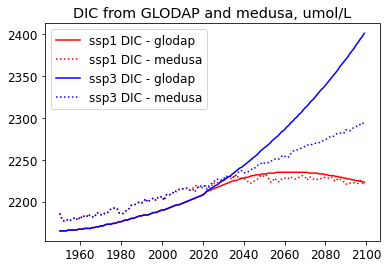

In [9]:
med_1A_DIC = td_1A.mn_DIC.sel({'quantity': 'mean'}).groupby('time_counter.year').mean()
ssp1_mean_med = med_1A_DIC.values

med_1B_DIC = td_1B.mn_DIC.sel({'quantity': 'mean'}).groupby('time_counter.year').mean()
ssp3_mean_med = med_1B_DIC.values

plt.figure()
plt.plot(yrs,ssp1_mean_umolL, color = 'r', linestyle = '-', label = 'ssp1 DIC - glodap')
plt.plot(yrs,ssp1_mean_med,color = 'r', linestyle = ':', label = 'ssp1 DIC - medusa')
plt.plot(yrs,ssp3_mean_umolL, color = 'b', linestyle = '-', label = 'ssp3 DIC - glodap')
plt.plot(yrs,ssp3_mean_med,color = 'b', linestyle = ':', label = 'ssp3 DIC - medusa')
plt.legend()
plt.title('DIC from GLODAP and medusa, umol/L')

## get reconstructed DIC etc etc this is so silly

In [10]:
from scipy.interpolate import interp1d

def get_DIC_values(yr,scen, verbose = False):
    'mean dic values from glodap for a given year, scenario, and also the depth profiles/gradients'
    
    tdir = '/gpfs/home/mep22dku/scratch/SOZONE/Tuning/GLODAP_AnthDIC/'
    t2 = glob.glob(f'{tdir}EstimatedDIC_{scen}_{yr}_umolL.nc')
    
    t = xr.open_dataset(t2[0])
    surf_dic = t.Reconstructed_DIC[0,0:40,:].weighted(calc_ar_dar[0,0:40,:]).mean().values
    dic_dp = t.Reconstructed_DIC[:,0:40,:].weighted(calc_ar_dar[:,0:40,:]).mean(dim = ['lat','lon'])

    dic_0 = dic_dp[0]
    depth_0 = dic_dp.depth[0]
    depths_first100 = dic_dp.depth[0:8]
    dics_first100 = dic_dp[0:8]
    f = interp1d(depths_first100, dics_first100, kind='linear')
    dic_100 = f(100)
    
    depths_second100 = dic_dp.depth[8:11]
    dics_second100 = dic_dp[8:11]
    f = interp1d(depths_second100, dics_second100, kind='linear')
    dic_200 = f(200)

    grad_dic_0_100 = ((dic_100-dic_0)/(100-depth_0)).values
    grad_dic_0_200 = ((dic_200-dic_0)/(200-depth_0)).values

    grad_dic_100_200 = ((dic_200-dic_100)/(200-100))
    grad_avg2 = (grad_dic_100_200+grad_dic_0_100)/2
    if verbose:
        print(grad_dic_0_100)
        print(grad_dic_0_200)
        print(grad_dic_100_200)
        print(grad_avg2)
    
    dic_1000 = dic_dp[18]
    DIC_1000_minus_0 = dic_1000 - dic_0
    
    return surf_dic, grad_avg2, DIC_1000_minus_0
    
    
surf_dic, grad_avg2, DIC_1000_minus_0 = get_DIC_values(1950,'ssp1')


In [11]:
tmask = xr.open_dataset(f'/gpfs/data/greenocean/software/resources/MEDUSA/mesh_mask.nc')
tmask_surf = tmask.tmask[0,0,:,:] * tmask.e1t[0,:,:] * tmask.e2t[0,:,:]

def make_yearlist_medusa(yr, scen):
    
    tdir = '/gpfs/data/greenocean/software/resources/MEDUSA/PROC2/'

    if yr < 2015:
        runid = 'bc370'
    else:
        if scen == 'ssp1':
            runid = 'be682'
        if scen == 'ssp3':
            runid = 'ce417'

    #bgc = xr.open_dataset(f'{tdir}medusa_{runid}_1y_{yr}_ptrc-T-CHLTADIC.nc')
    ts = xr.open_dataset(f'{tdir}nemo_{runid}_1y_{yr}_grid-T-TS.nc')
    #diadaux = xr.open_dataset(f'{tdir}medusa_{runid}_1y_{yr}_diad-T-aux.nc')
    
    return ts

def get_weighted(ts):
    
    T_mean = ts.votemper.isel(y=slice(0,114),deptht = 0).weighted(tmask_surf.isel(y=slice(0,114))).mean(dim = ['x','y'])
    S_mean = ts.vosaline.isel(y=slice(0,114),deptht = 0).weighted(tmask_surf.isel(y=slice(0,114))).mean(dim = ['x','y'])
    
    return T_mean, S_mean



In [12]:
def get_revelle(DIC_mean, TA_mean, T_mean, S_mean):
    
    DIC = np.zeros([12]); DIC[:] = DIC_mean
    ALK = np.zeros([12]); ALK[:] = TA_mean
    votemper = T_mean
    vosaline = S_mean
    
    tdra = np.ravel(DIC * 1e-3) #DIC, convert umol/L to mol/m3 (1000 L/m3)
    ttara = np.ravel(ALK * 1e-3) #Alkalinity, convert umol/L to mol/m3 (1000 L/m3)
    tsra = np.ravel(vosaline) #salt
    tsra_psu = np.ravel(vosaline) *35/35.16504 #g/kg to psu (salt)
    ttera = np.ravel(votemper)

    tdepth = np.zeros_like(ttera)
    tdepth[:] = 0
    ttera_is = gsw.t_from_CT(tsra,ttera,tdepth)
    tzero = np.zeros_like(tdepth)
    tpressure = np.zeros_like(tdepth)



    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

#     print(pco2)
#     print(BetaD)
#     BetaD = BetaD.reshape(12,114, 362)
#     BetaD[BetaD>100] = np.nan
#     Revelle = bgc.DIC.isel(y=slice(0,114),deptht = 0).copy()
#     Revelle[:] = BetaD
#     Revelle_mean = Revelle.isel(y=slice(0,114)).weighted(tmask_surf.isel(y=slice(0,114))).mean(dim = ['x','y'])

    return pco2, BetaD #Revelle_mean 

In [13]:
def get_all_pars(yr,scen):
    
    DIC_mean, grad_avg2, DIC_1000_minus_0 = get_DIC_values(yr,scen, verbose = False)
    
    tdir = '/gpfs/home/mep22dku/scratch/SOZONE/Tuning/GLODAP_AnthDIC/'
    t2 = glob.glob(f'{tdir}TAlk_umolL.nc')
    Talk = xr.open_dataset(t2[0])
    TA_mean = Talk.Reconstructed_DIC[0,0:40,:].weighted(calc_ar_dar[0,0:40,:]).mean()

    ts = make_yearlist_medusa(yr, scen)
    T_mean, S_mean = get_weighted(ts)
    
    #print(f'DIC {DIC_mean.values} TA {TA_mean.values}, T {T_mean.values}, S {S_mean.values}')
    
    pco2, Revelle = get_revelle(DIC_mean, TA_mean, T_mean, S_mean)
    
    return DIC_mean, grad_avg2, DIC_1000_minus_0, TA_mean, T_mean, S_mean, pco2, Revelle
DIC_mean, grad_avg2, DIC_1000_minus_0, TA_mean, T_mean, S_mean, pco2, Revelle = \
get_all_pars(1950,'ssp3')

In [14]:
def save_cchem_param_glodap(scen,scendez,yr):
    
    #bgc,ts, diadaux = make_yearlist(yr, scen)
    
    savenam = f'./data/cchem-param-glodap_scen-{scendez}-{yr}.nc'
    times = pd.date_range(f"{yr}/01/01",f"{yr}/12/11",freq='MS')#,closed='left')

    data_vars = {
                ### bgc gradients
        'grad_dDICdz': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'grad_DIC_surfdeep': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

                ### carbonate system variables
        'mn_kg': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_SST': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_Revfact': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_DIC': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_TA': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_pCO2': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        }

    coords = {'time_counter': (['time_counter'], times),
            'quantity': (['mean', 'stdev', 'max', 'min']),

    }
    # define global attributes
    attrs = {'made in':'scratch/BOE-SOcarbon/extract_BOE_parameters_from_MEDUSA.ipynb',
    'desc': ''
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)

    DIC_mean, grad_avg2, DIC_1000_minus_0, TA_mean, T_mean, S_mean, pco2, Revelle = \
    get_all_pars(yr,scen)
    
    ds['grad_dDICdz'][:,0] = grad_avg2 
    ds['grad_DIC_surfdeep'][:,0] = DIC_1000_minus_0; 
    ds['mn_kg'][:,0] = 0.065; 
    ds['mn_SST'][:,0] = T_mean.values; 
    ds['mn_Revfact'][:,0] = Revelle #.values; 
    ds['mn_DIC'][:,0] = DIC_mean#.values; 
    ds['mn_TA'][:,0] = TA_mean#.values; 
    ds['mn_pCO2'][:,0] = pco2#.values; 

    print(savenam)
    ds.to_netcdf(savenam)

    return ds
   
    
horse = False
if horse:
    for y in range(1950,2100):

        save_cchem_param_glodap('ssp1','1A',y)
        save_cchem_param_glodap('ssp3','1B',y)

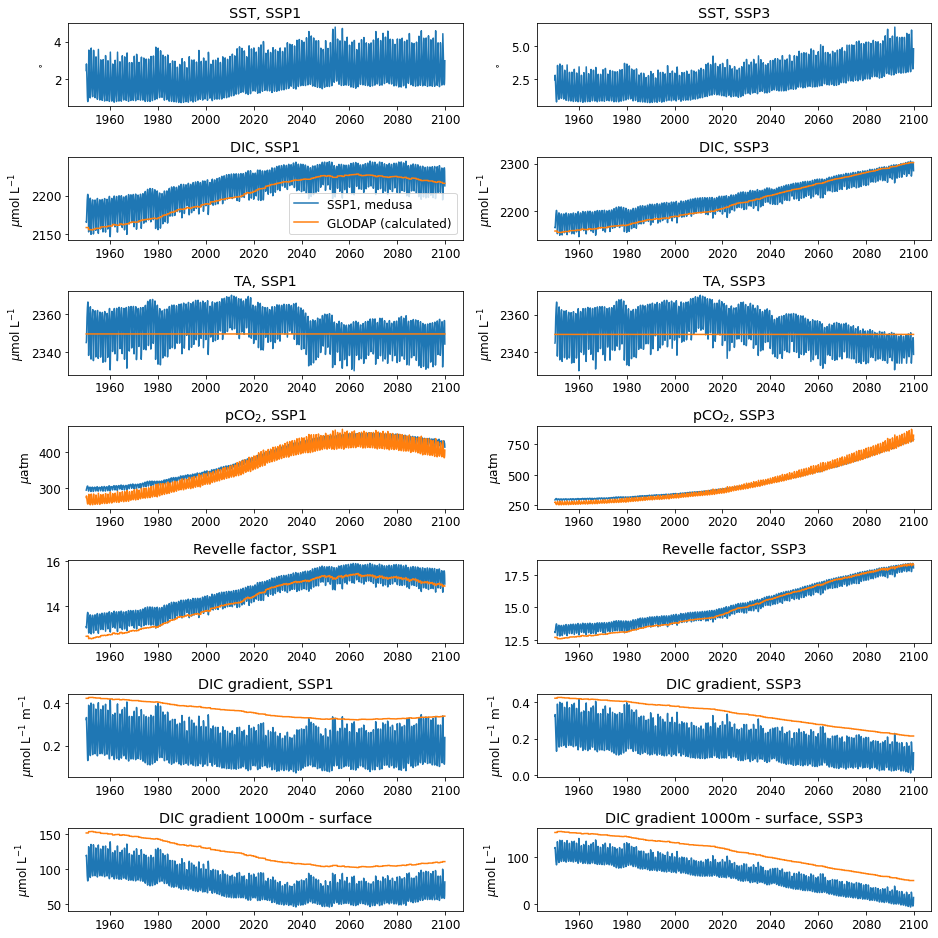

In [26]:
def make_yearlist(yrst, yrend, scen):

    tdir = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/'
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]

        t2 = glob.glob(f'{tdir}cchem-param-medusa_scen-{scen}-{yr}.nc')
        ylist.append(t2[0])

    return ylist

def make_yearlist_gd(yrst, yrend, scen):

    tdir = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/'
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]

        t2 = glob.glob(f'{tdir}cchem-param-glodap_scen-{scen}-{yr}.nc')
        ylist.append(t2[0])

    return ylist


def make_yearlist_gdsdp(yrst, yrend, scen):

    tdir = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/'
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]

        t2 = glob.glob(f'{tdir}cchem-param-glodap_sdp_scen-{scen}-{yr}.nc')
        ylist.append(t2[0])

    return ylist
    
    
ty_1A = make_yearlist(1950,2099,'1A')
ty_1B = make_yearlist(1950,2099,'1B')

td_1A = xr.open_mfdataset(ty_1A)
td_1B = xr.open_mfdataset(ty_1B)

####
ty_1A_gd = make_yearlist_gd(1950,2099,'1A')
ty_1B_gd = make_yearlist_gd(1950,2099,'1B')

td_1A_gd = xr.open_mfdataset(ty_1A_gd)
td_1B_gd = xr.open_mfdataset(ty_1B_gd)

###
ty_1A_gdsdp = make_yearlist_gdsdp(1950,2099,'1A')
ty_1B_gdsdp = make_yearlist_gdsdp(1950,2099,'1B')

td_1A_gdsdp = xr.open_mfdataset(ty_1A_gdsdp)
td_1B_gdsdp = xr.open_mfdataset(ty_1B_gdsdp)

fact = 1.1
fig, axs = plt.subplots(7,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0*2].plot(td_1A.time_counter, td_1A.mn_SST.sel({'quantity': 'mean'}), label = 'SSP1, medusa')
axs[1*2].plot(td_1A.time_counter, td_1A.mn_DIC.sel({'quantity': 'mean'}), label = 'SSP1, medusa')
axs[2*2].plot(td_1A.time_counter, td_1A.mn_TA.sel({'quantity': 'mean'}))
axs[3*2].plot(td_1A.time_counter, td_1A.mn_pCO2.sel({'quantity': 'mean'}))
axs[4*2].plot(td_1A.time_counter, td_1A.mn_Revfact.sel({'quantity': 'mean'}))
axs[5*2].plot(td_1A.time_counter, td_1A.grad_dDICdz.sel({'quantity': 'mean'}))
axs[6*2].plot(td_1A.time_counter, td_1A.grad_DIC_surfdeep.sel({'quantity': 'mean'}))

axs[0*2+1].plot(td_1B.time_counter, td_1B.mn_SST.sel({'quantity': 'mean'}), label = '')
axs[1*2+1].plot(td_1B.time_counter, td_1B.mn_DIC.sel({'quantity': 'mean'}))
axs[2*2+1].plot(td_1B.time_counter, td_1B.mn_TA.sel({'quantity': 'mean'}))
axs[3*2+1].plot(td_1B.time_counter, td_1B.mn_pCO2.sel({'quantity': 'mean'}))
axs[4*2+1].plot(td_1B.time_counter, td_1B.mn_Revfact.sel({'quantity': 'mean'}))
axs[5*2+1].plot(td_1B.time_counter, td_1B.grad_dDICdz.sel({'quantity': 'mean'}))
axs[6*2+1].plot(td_1B.time_counter, td_1B.grad_DIC_surfdeep.sel({'quantity': 'mean'}))

# axs[0*2].plot(td_1A_gd.time_counter, td_1A_gd.mn_SST.sel({'quantity': 'mean'}), label = 'SSP1, glodap simple scaling')
# axs[1*2].plot(td_1A_gd.time_counter, td_1A_gd.mn_DIC.sel({'quantity': 'mean'}))
# axs[2*2].plot(td_1A_gd.time_counter, td_1A_gd.mn_TA.sel({'quantity': 'mean'}))
# axs[3*2].plot(td_1A_gd.time_counter, td_1A_gd.mn_pCO2.sel({'quantity': 'mean'}))
# axs[4*2].plot(td_1A_gd.time_counter, td_1A_gd.mn_Revfact.sel({'quantity': 'mean'}))
# axs[5*2].plot(td_1A_gd.time_counter, td_1A_gd.grad_dDICdz.sel({'quantity': 'mean'}))
# axs[6*2].plot(td_1A_gd.time_counter, td_1A_gd.grad_DIC_surfdeep.sel({'quantity': 'mean'}))

# axs[0*2+1].plot(td_1B_gd.time_counter, td_1B_gd.mn_SST.sel({'quantity': 'mean'}), label = '')
# axs[1*2+1].plot(td_1B_gd.time_counter, td_1B_gd.mn_DIC.sel({'quantity': 'mean'}))
# axs[2*2+1].plot(td_1B_gd.time_counter, td_1B_gd.mn_TA.sel({'quantity': 'mean'}))
# axs[3*2+1].plot(td_1B_gd.time_counter, td_1B_gd.mn_pCO2.sel({'quantity': 'mean'}))
# axs[4*2+1].plot(td_1B_gd.time_counter, td_1B_gd.mn_Revfact.sel({'quantity': 'mean'}))
# axs[5*2+1].plot(td_1B_gd.time_counter, td_1B_gd.grad_dDICdz.sel({'quantity': 'mean'}))
# axs[6*2+1].plot(td_1B_gd.time_counter, td_1B_gd.grad_DIC_surfdeep.sel({'quantity': 'mean'}))

#axs[0*2].plot(td_1A_gdsdp.time_counter, td_1A_gdsdp.mn_SST.sel({'quantity': 'mean'}), label = 'GLODAP (calculated)')
axs[1*2].plot(td_1A_gdsdp.time_counter, td_1A_gdsdp.mn_DIC.sel({'quantity': 'mean'}), label = 'GLODAP (calculated)')
axs[2*2].plot(td_1A_gdsdp.time_counter, td_1A_gdsdp.mn_TA.sel({'quantity': 'mean'}))
axs[3*2].plot(td_1A_gdsdp.time_counter, td_1A_gdsdp.mn_pCO2.sel({'quantity': 'mean'}))
axs[4*2].plot(td_1A_gdsdp.time_counter, td_1A_gdsdp.mn_Revfact.sel({'quantity': 'mean'}))
axs[5*2].plot(td_1A_gdsdp.time_counter, td_1A_gdsdp.grad_dDICdz.sel({'quantity': 'mean'}))
axs[6*2].plot(td_1A_gdsdp.time_counter, td_1A_gdsdp.grad_DIC_surfdeep.sel({'quantity': 'mean'}))

#axs[0*2+1].plot(td_1B_gdsdp.time_counter, td_1B_gdsdp.mn_SST.sel({'quantity': 'mean'}), label = '')
axs[1*2+1].plot(td_1B_gdsdp.time_counter, td_1B_gdsdp.mn_DIC.sel({'quantity': 'mean'}))
axs[2*2+1].plot(td_1B_gdsdp.time_counter, td_1B_gdsdp.mn_TA.sel({'quantity': 'mean'}))
axs[3*2+1].plot(td_1B_gdsdp.time_counter, td_1B_gdsdp.mn_pCO2.sel({'quantity': 'mean'}))
axs[4*2+1].plot(td_1B_gdsdp.time_counter, td_1B_gdsdp.mn_Revfact.sel({'quantity': 'mean'}))
axs[5*2+1].plot(td_1B_gdsdp.time_counter, td_1B_gdsdp.grad_dDICdz.sel({'quantity': 'mean'}))
axs[6*2+1].plot(td_1B_gdsdp.time_counter, td_1B_gdsdp.grad_DIC_surfdeep.sel({'quantity': 'mean'}))


axs[2].legend()

tits = ['SST, SSP1', 'SST, SSP3',\
       'DIC, SSP1', 'DIC, SSP3',\
       'TA, SSP1', 'TA, SSP3',\
       'pCO$_2$, SSP1', 'pCO$_2$, SSP3',\
       'Revelle factor, SSP1', 'Revelle factor, SSP3',\
       'DIC gradient, SSP1', 'DIC gradient, SSP3',\
       'DIC gradient 1000m - surface', 'DIC gradient 1000m - surface, SSP3',\
       ]

labs = ['$^{\circ}$','$^{\circ}$','$\mu$mol L$^{-1}$','$\mu$mol L$^{-1}$',\
       '$\mu$mol L$^{-1}$','$\mu$mol L$^{-1}$',\
       '$\mu$atm','$\mu$atm',\
       '','',\
       '$\mu$mol L$^{-1}$ m$^{-1}$','$\mu$mol L$^{-1}$ m$^{-1}$',\
       '$\mu$mol L$^{-1}$','$\mu$mol L$^{-1}$',]

for i in range(0,14):
    axs[i].set_title(tits[i])
    axs[i].set_ylabel(labs[i])
    
plt.tight_layout()

In [16]:
gd_ssp3 = td_1B_gd.mn_pCO2.sel({'quantity': 'mean'}).groupby('time_counter.year').mean().values
gd_ssp1 = td_1A_gd.mn_pCO2.sel({'quantity': 'mean'}).groupby('time_counter.year').mean().values

med_ssp3 = td_1B.mn_pCO2.sel({'quantity': 'mean'}).groupby('time_counter.year').mean().values
med_ssp1 = td_1A.mn_pCO2.sel({'quantity': 'mean'}).groupby('time_counter.year').mean().values


In [17]:
co2_ssp1 = '/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp1-26.dat'
co2_ssp3 = '/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp3-70.dat'

atmo_co2_ssp1 = pd.read_csv(co2_ssp1, sep='\t')
atmo_co2_ssp3 = pd.read_csv(co2_ssp3, sep='\t')



yr = atmo_co2_ssp1['1650.042'].values
co2atm_ssp1 = atmo_co2_ssp1['276.58'].values
co2atm_ssp3 = atmo_co2_ssp3['276.58'].values


yrmns = np.arange(1950,2100,1)
yrmn_co2_ssp1 = np.arange(1950,2100,1)
yrmn_co2_ssp1 = yrmn_co2_ssp1.astype('float')
yrmn_co2_ssp3 = np.arange(1950,2100,1)
yrmn_co2_ssp3 = yrmn_co2_ssp3.astype('float')


for i in range(1950,2100):
    yrmn_co2_ssp1[i-1950] = np.nanmean(co2atm_ssp1[(yr >= i) & (yr< i+1)])
    yrmn_co2_ssp3[i-1950] = np.nanmean(co2atm_ssp3[(yr >= i) & (yr< i+1)])


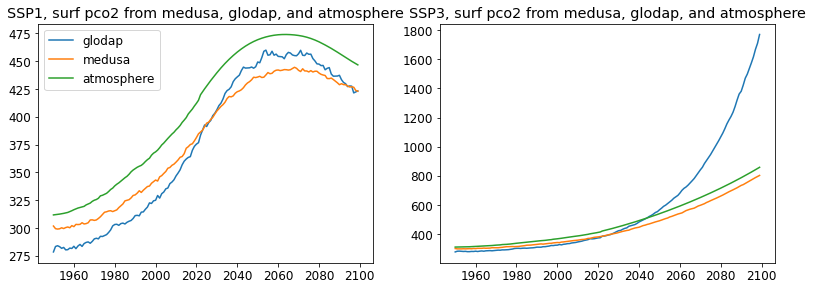

In [18]:
fact = 1.1
fig, axs = plt.subplots(1,2, figsize=(12*fact, 4*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(np.arange(1950,2100,1),gd_ssp1, label = 'glodap')
axs[0].plot(np.arange(1950,2100,1),med_ssp1,  label = 'medusa')
axs[0].plot(np.arange(1950,2100,1),yrmn_co2_ssp1, label = 'atmosphere')

axs[1].plot(np.arange(1950,2100,1),gd_ssp3, label = 'glodap')
axs[1].plot(np.arange(1950,2100,1),med_ssp3,  label = 'medusa')
axs[1].plot(np.arange(1950,2100,1),yrmn_co2_ssp3, label = 'atmosphere')

axs[0].set_title('SSP1, surf pco2 from medusa, glodap, and atmosphere')
axs[1].set_title('SSP3, surf pco2 from medusa, glodap, and atmosphere')
axs[0].legend()

In [19]:
print('go')

go


In [20]:
w = xr.open_dataset('/gpfs/home/e031/scratch/Data/Maremip/MarEDat20120716Diatoms.nc', decode_times=False)

In [21]:
q = w.BIOMASS.isel(DEPTH = 0).isel(LATITUDE = slice(0,40)).mean(dim = ['LATITUDE', 'LONGITUDE'])
print(q)

<xarray.DataArray 'BIOMASS' (TIME: 12)>
array([0.24824515, 3.9904542 ,        nan, 4.5067306 , 7.9989996 ,
       0.8330667 ,        nan,        nan,        nan,        nan,
              nan,        nan], dtype=float32)
Coordinates:
    DEPTH    float32 0.0
  * TIME     (TIME) float32 1.314e+06 3.942e+06 6.57e+06 ... 2.759e+07 3.022e+07


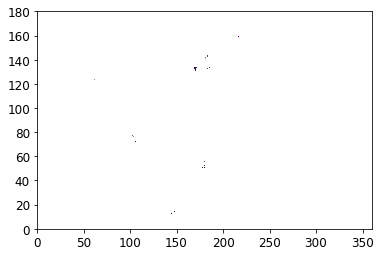

In [22]:
plt.pcolormesh(w.BIOMASS[0,0,:,:])


NameError: name 'ir_surf' is not defined

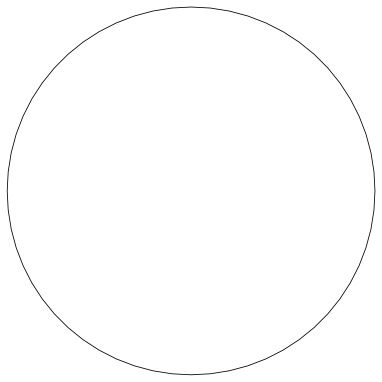

In [23]:
fact = 0.5
tfig = plt.figure(figsize=[14.5*2*fact, 14.5*fact])
ax1 = tfig.add_subplot(1, 2, 1, projection=ccrs.Orthographic(0, -90))
lons = ir_surf.lon_broad.values
lats = ir_surf.lat_broad.values
tdat = ir_surf.Fe_D_CONC_BOTTLE.values
tvmin = 0
tvmax = 1
tticks = np.arange(0,1.25,0.25)
dotsize = 40
scatter_southern(fig, ax1, lons, lats, tdat, tvmin, dotsize,
                  tvmax, tticks, northex = -50, fs = 20, 
                  tit = f'geotraces obs. iron, nmol/kg \n (top 20m) \n median {np.nanmedian(ir_surf.Fe_D_CONC_BOTTLE.values)}', \
                 cbarlab = '', tcmap = 'Spectral', lm = True, cbr = True)


ax1 = tfig.add_subplot(1, 2, 2, projection=ccrs.Orthographic(0, -90))
lons = ir_depth.lon_broad.values
lats = ir_depth.lat_broad.values
tdat = ir_depth.Fe_D_CONC_BOTTLE.values
tvmin = 0
tvmax = 1
tticks = np.arange(0,1.25,0.25)
dotsize = 40
scatter_southern(fig, ax1, lons, lats, tdat, tvmin, dotsize,
                  tvmax, tticks, northex = -50, fs = 20, 
                  tit = f'geotraces obs. iron, nmol/kg \n (800m - 1200m) \n median {np.nanmedian(ir_depth.Fe_D_CONC_BOTTLE.values)}', \
                 cbarlab = '', tcmap = 'Spectral', lm = True, cbr = True)

tfig.text(0.2,0.0,\
        s ='made in scratch/BOE-SOcarbon/iron-cycle.ipynb, data: https://geotraces.webodv.awi.de/IDP2021_v2')

In [ ]:
w = xr.open_dataset('./data/glodap_singledp.nc')

In [ ]:
w.DIC_ssp1[140,:]